In [2]:
import noise
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

In [3]:
# In a 1024x1024 image, we will create 3 simulated variables in a dictionary named world by using Perlin Noise variables
shape = (1024,1024)

world={}

# The first variable will represent a 'general' slope (this is actually not the way to proceed, however
# it works as a demonstration)

world['1'] = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world['1'][i][j] = noise.pnoise2(i/200, 
                                    j/200, 
                                    octaves=6, 
                                    persistence=0.5, 
                                    lacunarity=2.0, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=2)
        
# The second variable will represent a resume of the meteorological conditions.
world['2'] = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world['2'][i][j] = noise.pnoise2(i/(150), 
                                    j/(150), 
                                    octaves=3, 
                                    persistence=0.3, 
                                    lacunarity=0.1, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)
        
# Finally the fuel will be represented by this variable. 
world['3'] = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world['3'][i][j] = noise.pnoise2(i, 
                                    j, 
                                    octaves=5, 
                                    persistence=1.1, 
                                    lacunarity=.1, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)

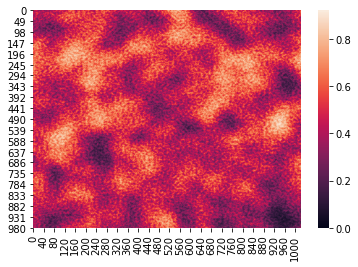

In [4]:
# Instant meteorological conditions:
meteo = world['2']

# Fuel Opportunity:
fuel = world['3']

# Slope direction:
slope = world['1']


# To genrate a probabilty, we must generate a value between 0 and 1 with a combination of the other variables
# therefore we will standarize the representations and then generate a number between 0 and 1 given the conditions. 
worlds = [(world[i]-np.mean(world[i]))/np.std(world[i]) for i in ['1','2','3']]
prob = 1/3*worlds[0]+1/3*worlds[1]+1/3*worlds[2] - .3*np.random.random(shape)
prob = 1/(1+np.exp(-1*prob))
sns.heatmap(prob, vmin=0)

In [5]:
#i,j = np.random.choice(1024),np.random.choice(1024)
# Create another matrix with the "fire" content

Fire = np.zeros(shape)
i,j=254,840

Fire[i][j]=1

queue=[(i,j)]
longer = []
prob_time=[]
fire_time=[]
while queue!=[]:
    # Take the first element of the list (remove it and gain the values)
    i,j=queue.pop(0)
    
    if i== 1023 or j==1023 or i==0 or j==0:
        break

    # Fire has (for now 4 closest neighbours to go to)
    if np.random.random() < prob[i+1][j]:
        Fire[i+1][j]=1
        queue.append((i+1,j))
        prob[i+1][j]=0
    if np.random.random() < prob[i][j+1]:
        Fire[i][j+1]=1
        queue.append((i,j+1))
        prob[i][j+1]=0
    if np.random.random() < prob[i-1][j]:
        Fire[i-1][j]=1
        queue.append((i-1,j))
        prob[i-1][j]=0
    if np.random.random() < prob[i][j-1]:
        Fire[i][j-1]=1
        queue.append((i,j-1))
        prob[i-1][j]=0

    queue=set(queue)
    queue=list(queue)
    longer.append(len(queue))
    prob_time.append(prob)
    #fire_time.append([plt.imshow(Fire)])


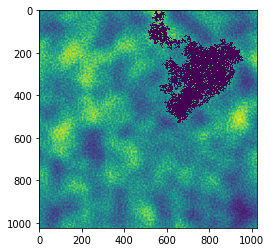

In [6]:
plt.imshow(prob_time[0])
plt.show()

In [ ]:
fig = plt.figure()
ani = animation.ArtistAnimation(fig, fire_time, interval=10, blit=True,
                                repeat_delay=1000)
plt.show()

In [ ]:


ims = []
for i in range(len(prob_time[:50])):
    im = plt.imshow(fire_time[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

